In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import yfinance as yf
import fredapi as fa
from datetime import date, timedelta
#from Sector_Exposure import Rate_Exposures
import numpy as np
import matplotlib.pyplot as plt
import Useful_Functions as u
from statsmodels.tsa.stattools import adfuller
from Exposure_Report import Exposure
from scipy.stats.mstats import normaltest
from Yield_Curves import YieldCurve

fred = fa.Fred('4fb0ce271d0f66f4b5b3904b4aaf1dd0')

In [41]:
import pandas_ta as ta

# 
macro = pd.read_csv("macro_data.csv", index_col="Date")

macro['semiconductors'] = yf.download("SOXX", start= '2013-01-04', progress=False)['Close']
macro['sec_volume'] = yf.download("SOXX", start= '2013-01-04', progress=False)['Volume']
macro['sma_spread'] = ta.sma(macro['semiconductors'], 5) - ta.sma(macro['semiconductors'], 252)

macro = macro.dropna()

# , "SP-500"
exposure = Exposure(macro, 252, 21, [i for i in macro.columns if i != "semiconductors"])

dataframe = exposure.forward_returns_daily.copy()
#dataframe['sma_spread'] = ta.sma(macro['semiconductors'], 5) - ta.sma(macro['semiconductors'], 252)
dataframe['above_market'] = [int(i) for i in (dataframe.semiconductors > 0.0)]

dataframe

,semiconductors,Real Yield_scores,Yield Curve_scores,inflation_scores,uncertainty_index_scores,market_volume_scores,market_volatility_scores,sec_volume_scores,sma_spread_scores,above_market
Date,,,,,,,,,,
2015-01-23,0.054468,-3.0,-3.0,-2.0,1.0,0.0,2.0,0.0,-1.0,1
2015-01-26,0.047097,-3.0,-3.0,-2.0,0.0,0.0,2.0,-1.0,-1.0,1
2015-01-27,0.073362,-4.0,-3.0,0.0,-1.0,0.0,2.0,2.0,-1.0,1
2015-01-28,0.075266,-5.0,-4.0,-1.0,1.0,1.0,2.0,1.0,-1.0,1
2015-01-29,0.104060,-3.0,-3.0,-1.0,-2.0,1.0,2.0,-1.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...
2022-05-04,-0.029461,4.0,-1.0,1.0,0.0,2.0,4.0,1.0,-3.0,0
2022-05-05,0.021706,5.0,0.0,0.0,-1.0,1.0,5.0,1.0,-3.0,1
2022-05-06,0.039135,5.0,1.0,1.0,3.0,1.0,4.0,0.0,-2.0,1


In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

cutoff = int(len(dataframe)*.7)

train_df = dataframe.iloc[:,1:][:cutoff]
test_df = dataframe.iloc[:,1:][cutoff:]

X = train_df.iloc[:,:-1]
Y = train_df.iloc[:,-1]
XTEST = test_df.iloc[:,:-1]
YTEST = test_df.iloc[:,-1]


In [43]:

forest = RandomForestClassifier().fit(X,Y)
forest_preds = forest.predict(XTEST)

important_features = pd.Series(forest.feature_importances_, index = X.columns)
accuracy_score(YTEST, forest_preds)


0.6941176470588235

<AxesSubplot:>

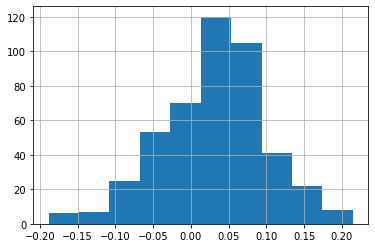

In [49]:

performance = pd.DataFrame()
performance['above'] = YTEST
performance['pred'] = forest_preds
performance['correct_guess'] = 1 - abs(performance['above'] - performance['pred'])
performance['rets'] = dataframe['semiconductors'][cutoff:]


#performance.rets.loc[ (performance.correct_guess == 1) & (performance.pred == 1) ].hist()

# (performance.correct_guess == 0) & 
performance.rets.loc[ performance.pred == 1 ].hist()


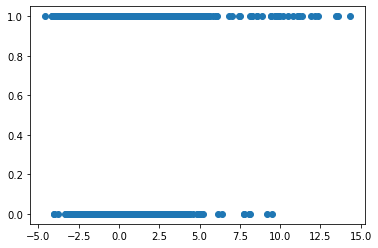

In [92]:



raw_df = exposure.forward_returns_daily_raw.copy().dropna()
raw_df['above_market'] = dataframe['above_market']